# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'
data_dir = '../data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

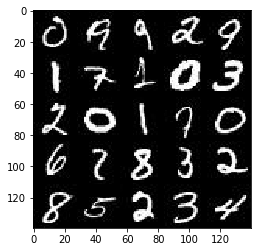

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

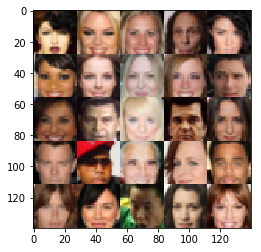

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), "z_input")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function: Hidden layers: conv + batch_norm + leaky ReLU
    
    alpha = 0.15 # reduce alpha
    # kp = 0.8 # - dropout is not neccesary since batch_norm is used
    with tf.variable_scope("discriminator", reuse = reuse ):
    # input layer is: 28x28x3 => 14x14x64
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", activation=None)
        h1 = tf.maximum(alpha*h1, h1)
    
    # h2 => 7x7x128
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding="same", activation=None)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha*h2, h2)
      # h2 = tf.nn.dropout(h2, kp)
    
    # h3 => 4x3x256
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding="same", activation=None)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha*h3,h3)   
      # h3 = tf.nn.dropout(h3, kp)
        
    # Flatten it 
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function: Hidden layers: Tconv + batch_norm + leaky ReLU
    alpha = 0.15 # reduce alpha
    # kp = 0.8 # - dropout is not neccesary since batch_norm is used
    with tf.variable_scope("generator", reuse = not is_train):
    # h1 = fully connected layer
        h1 = tf.layers.dense(z, 2*2*512)
        
    # reshape to start convolutional stack -> 2x2x512
        h1 = tf.reshape(h1, (-1, 2,2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha*h1, h1)
    
    # h2 = conv => 7x7x256 - VALID padding
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding="valid", activation=None)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha*h2, h2)
        #h2 = tf.nn.dropout(h2, kp) 
        
    # h3 = conv => 14x14x128
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding="same", activation=None)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha*h3, h3)
        #h3 = tf.nn.dropout(h3, kp)
    
    # h4 = conv => 14x15x64
        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides=1, padding="same", activation=None)
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(alpha*h4, h4)
        #h4 = tf.nn.dropout(h4,kp)

    # output layer = 28x28xout_dim(5)
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 5, strides=2, padding="same", activation=None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth) ))
    
    d_loss_fake = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)  ))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.ones_like(d_model_fake)  ))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get variables 
    t_vars = tf.trainable_variables()
    d_vars = [ var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [ var for var in t_vars if var.name.startswith("generator")]
    
    # Optimize:
    with tf.control_dependencies( tf.get_collection(tf.GraphKeys.UPDATE_OPS )  ):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    show_every  = 100
    print_every = 10
    steps = 0
    n_images = 16
    losses = []
    

    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # 1 - sample random noise 
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # 2 - Run optimizers 
                _ = sess.run(d_opt, feed_dict={input_z: sample_z, input_real:batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, input_real:batch_images, lr:learning_rate})
                
                # print loss 
                if steps % print_every == 0: 
                        d_loss_tr = d_loss.eval({input_z: sample_z, input_real:batch_images} )
                        g_loss_tr = g_loss.eval({input_z: sample_z} )
                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_tr),
                          "Generator Loss: {:.4f}".format(g_loss_tr))
                        losses.append((d_loss_tr, g_loss_tr))
                
                # show images
                if steps%show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)
        saver.save(sess, './model.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 5.5173
Epoch 1/2... Discriminator Loss: 0.4813... Generator Loss: 11.0790
Epoch 1/2... Discriminator Loss: 5.3768... Generator Loss: 0.0095
Epoch 1/2... Discriminator Loss: 3.1899... Generator Loss: 1.4604
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 1.4543
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 3.9693
Epoch 1/2... Discriminator Loss: 0.6364... Generator Loss: 1.8576
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 1.7631
Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 5.8805
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 7.5918


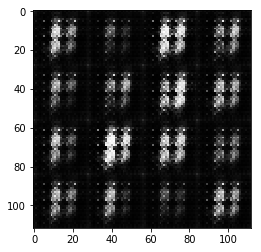

Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 8.1473
Epoch 1/2... Discriminator Loss: 0.5977... Generator Loss: 2.3246
Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 3.5388
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 1.9943
Epoch 1/2... Discriminator Loss: 0.4601... Generator Loss: 2.9704
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 2.9189
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.5049
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.8223
Epoch 1/2... Discriminator Loss: 0.6351... Generator Loss: 2.2264
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 2.5711


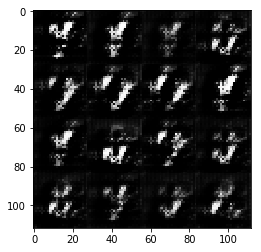

Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 1.6567
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 4.0478
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.7275
Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 1.6249
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 2.1505
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.9640
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.3673
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 2.0500
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 2.9279
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 1.8821


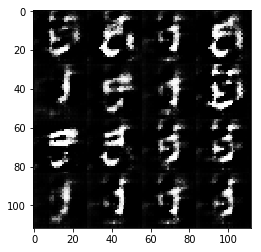

Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.8849
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.8326
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.7392
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.5133
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.4801
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.6215
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.1820
Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 0.8758... Generator Loss: 1.1860


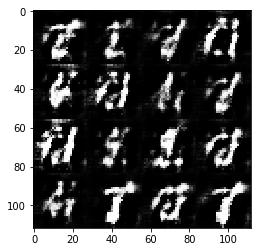

Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 2.4936
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 2.8105
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 3.5371
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.7111
Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 2.4813
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 2.6685
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 2.0665
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 0.9442


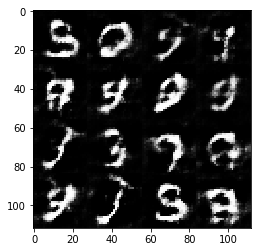

Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.0951
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.4609
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.0578
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.0140
Epoch 1/2... Discriminator Loss: 0.9220... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 2.0987


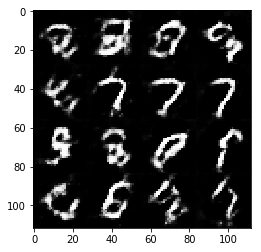

Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.4034
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.4098
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 2.4580
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 2.1510
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.1640
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.4108
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.6733
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.0456
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.7574


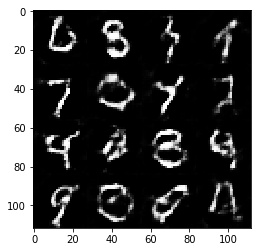

Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 1.9493
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.8263
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.2791
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.1023
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 1.0399
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 1.7352
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 1.1333


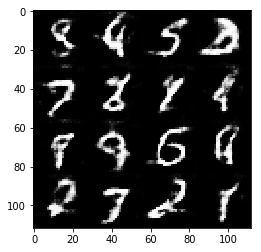

Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 1.1523
Epoch 1/2... Discriminator Loss: 1.5297... Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 2.1752
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 1.0097


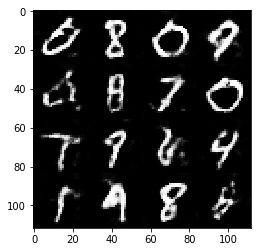

Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 1.1380
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 1.7091
Epoch 1/2... Discriminator Loss: 1.1788... Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 1.8692... Generator Loss: 0.3011
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 1.5715
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 0.9371


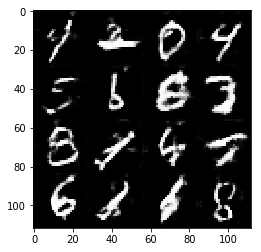

Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 1.9921
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 2.1738
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.8135


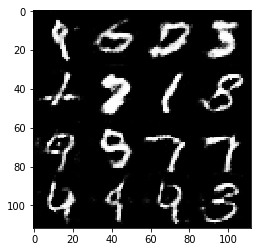

Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 1.0709
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 1.6597
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.3311
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 1.4861
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.4985
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.5379


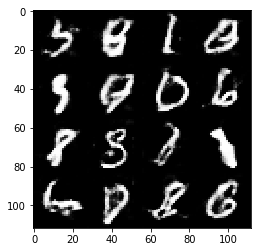

Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.9940
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 1.3217
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.7817
Epoch 2/2... Discriminator Loss: 0.9409... Generator Loss: 1.4826
Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 2.0088


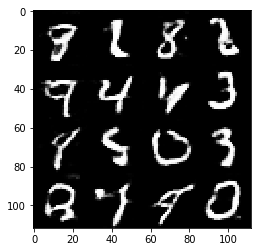

Epoch 2/2... Discriminator Loss: 0.9254... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.4663
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 1.3296
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 1.4496
Epoch 2/2... Discriminator Loss: 1.6582... Generator Loss: 0.3780
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 1.7810
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 1.1562


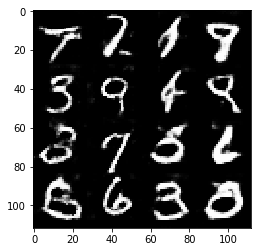

Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.8620
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 1.2651
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.7147
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.8029


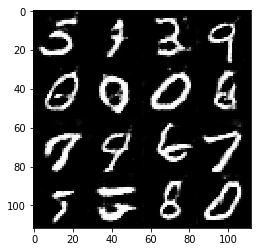

Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.6641
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 2.5455... Generator Loss: 3.5284
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 0.7796
Epoch 2/2... Discriminator Loss: 1.7583... Generator Loss: 0.3254


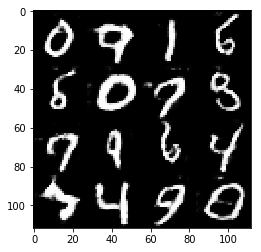

Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.2070
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 1.2079
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 1.4546
Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 1.8588
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.8028


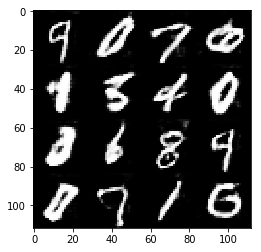

Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.8554
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 1.7784
Epoch 2/2... Discriminator Loss: 1.7205... Generator Loss: 0.3560
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.4321
Epoch 2/2... Discriminator Loss: 1.3778... Generator Loss: 0.5207
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.5086
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.5585
Epoch 2/2... Discriminator Loss: 1.5348... Generator Loss: 1.8993


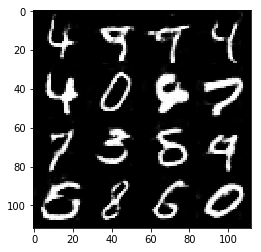

Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 2.0369
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 1.5340... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 1.6698... Generator Loss: 0.3895


In [13]:
batch_size = 64 # reduce batch size from 128 to 64 
z_dim = 100
learning_rate = 0.0006
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.8820
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 3.9928
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 8.2253
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 2.1920
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 2.3756
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 2.3241


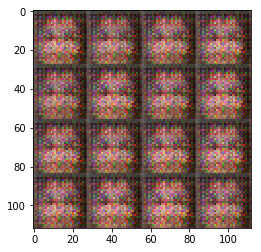

Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.8224
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.0331
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 0.7183... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 2.4707
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 2.0682


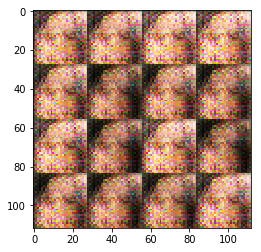

Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.9919
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.1882
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 2.8885
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.4508
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 2.6181
Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 2.7503
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 2.8418
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.5251


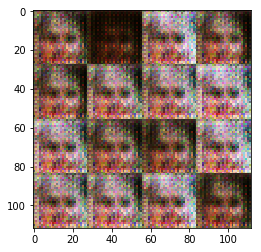

Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.8547
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 2.2063
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 2.2006
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.6935
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.5396


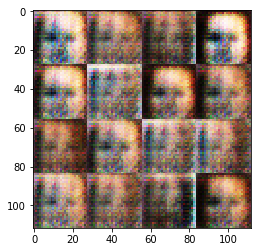

Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 3.0696
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.9867
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.8515


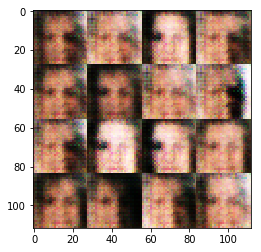

Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.7796
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 2.5437
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 3.5827
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.2802
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 2.3910
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.5096


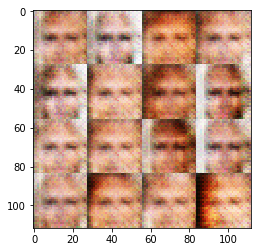

Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 2.6272
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.7903
Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 2.1436
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 2.3617
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.6744


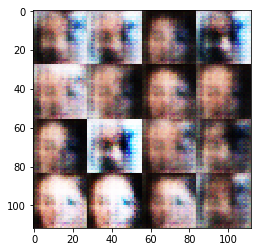

Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 2.5302
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 2.5344
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 3.0797
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.9538
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.2595
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 2.9569
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.9210


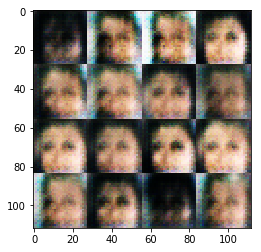

Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.9460
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 2.4446
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.7396


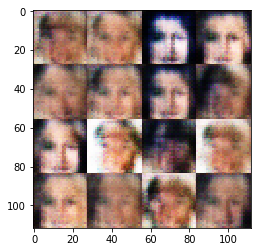

Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 2.5649
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.6117
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 2.2655


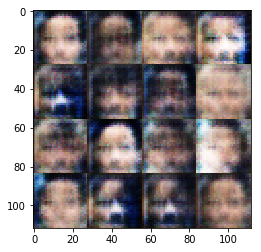

Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 1.6705... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.7944
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 2.6999
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.8692
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.9423


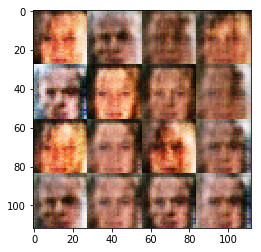

Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 2.8552
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.1292
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 0.9198... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.8484
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 2.0247
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.1215


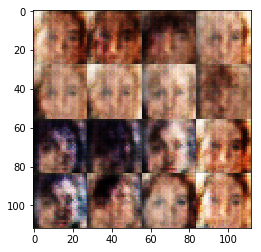

Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.0612
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 2.0060
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.6364
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.4869


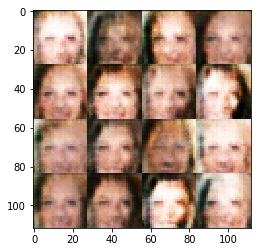

Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 2.5525
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.7134


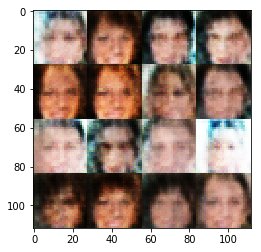

Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.4978
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 2.0476
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.9867
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.7483
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 1.3685
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.4292


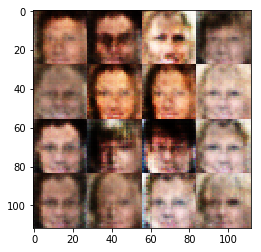

Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 2.2774
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 2.9612
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.7701
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.5059


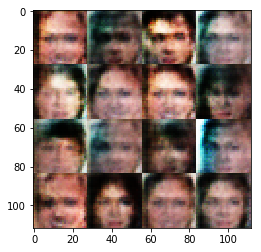

Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.7347
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 2.0414
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.7851
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9628


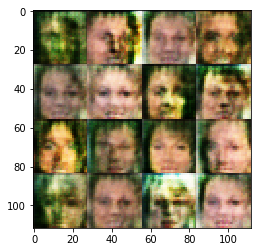

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.9986
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.2165
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.4008
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.4279


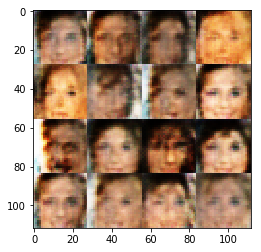

Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.9108
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.0882


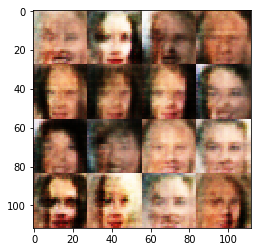

Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.7442
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.5924
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.2571
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.4479
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.8884


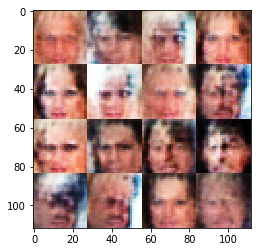

Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 2.4279
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 2.2349
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 2.1029
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.8115


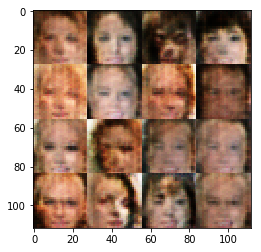

Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.5582
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.5779
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.3118


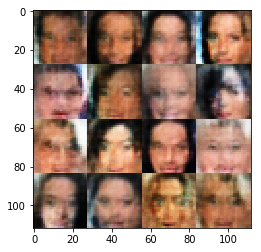

Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.5877
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.3122
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.6192


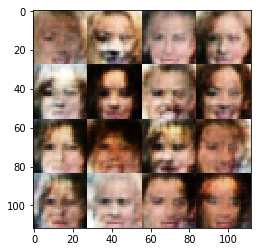

Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.4761
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.4523


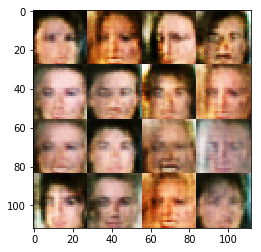

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.1851
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.8164
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.3540


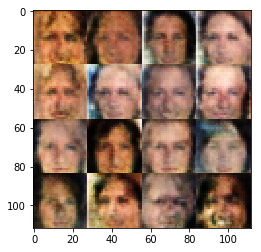

Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.1457
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9281


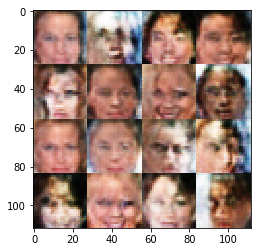

Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.6917
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7330


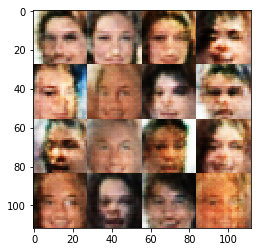

Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.4147
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.9969


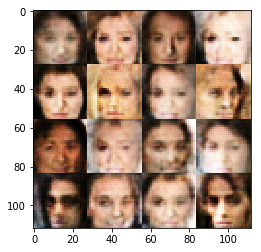

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.5863
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.0138


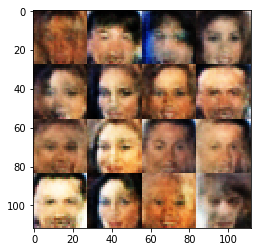

Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.4571


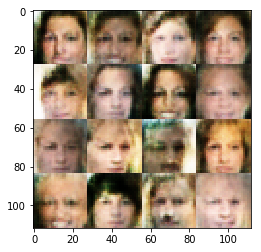

Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.4702
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.3439
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.0220


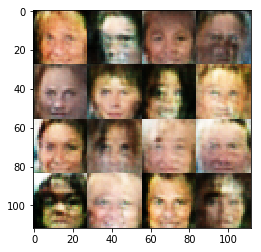

Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.3056


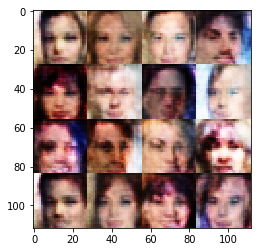

Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.1983


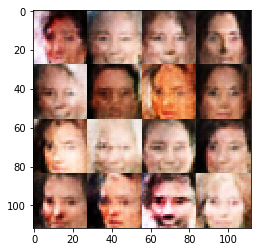

Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 1.4552
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.4761
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.9146


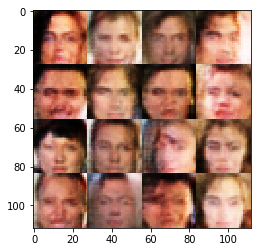

Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.8919


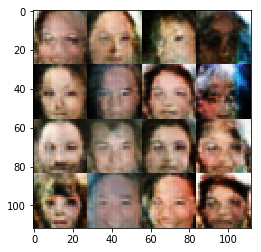

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.0676


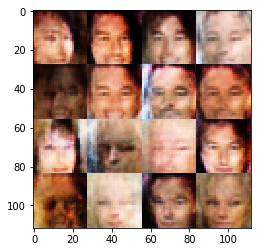

Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.2797
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8705


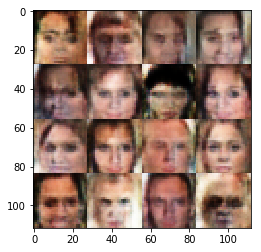

Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.6157
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.4151
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.6048


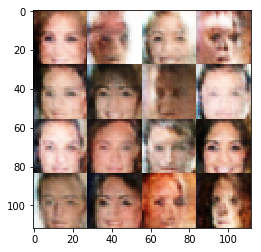

Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.0717
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.1334
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.1553
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.1058


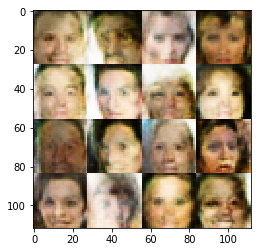

Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.2126


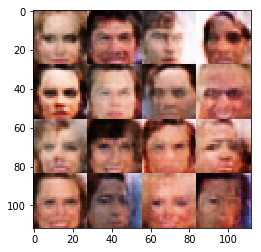

Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.4719
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7442


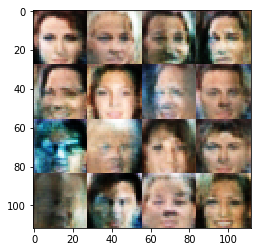

Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.4826
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.5491
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.0133


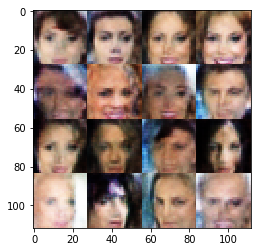

Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.2129


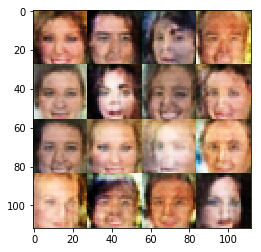

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.6500
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0524


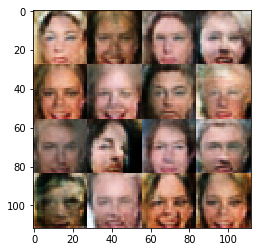

Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0782


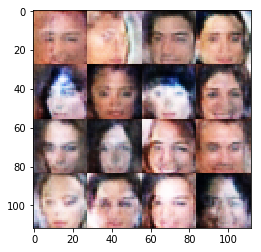

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.7841


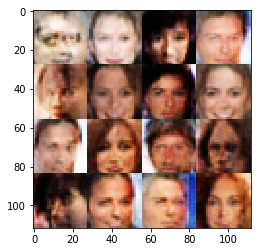

Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8263


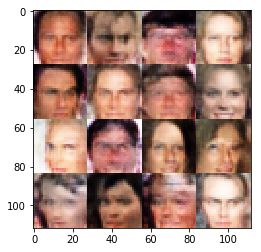

Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.0397


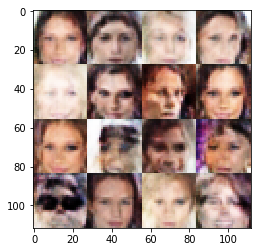

Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.6011
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8778


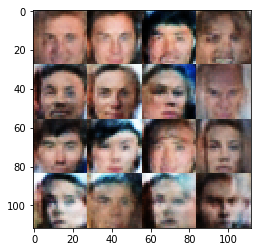

Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.3133


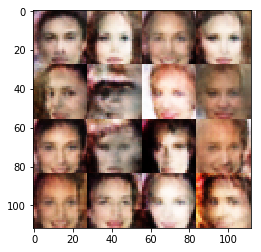

Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.0844


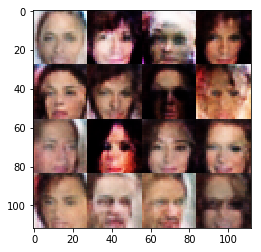

Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.2748


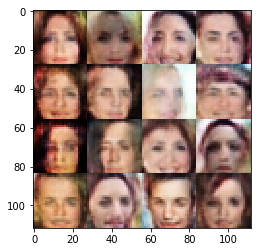

Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.3257


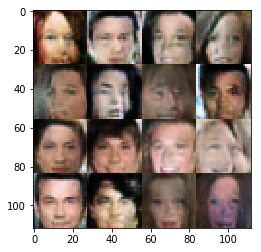

Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.6804
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.7773


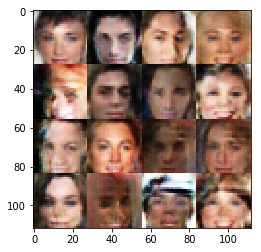

Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.2085


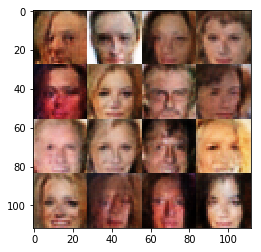

Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.4799
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5847


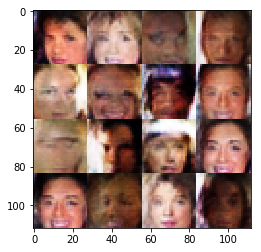

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.2182


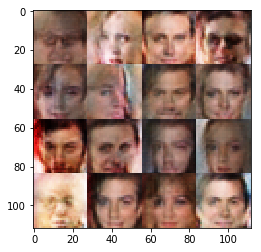

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.7545
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9602


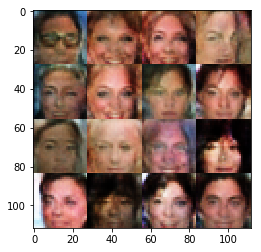

Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.8280


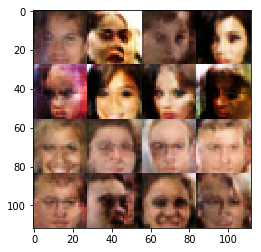

Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.9823


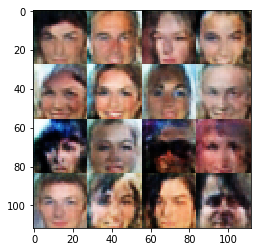

Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.9429
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.8500


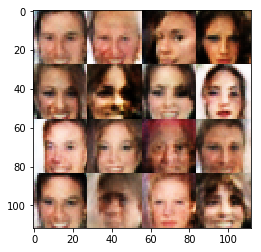

Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.1254
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 1.0068


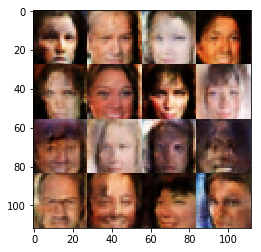

Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.9293


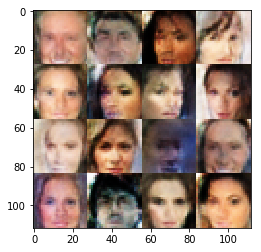

Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.2696


In [14]:
batch_size = 32 # reduce batch_size from 128 to 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.